In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd

In [4]:
PATH = "data/competitions/dog-breed-identification"
#PATH = "data/competitions/dogs-vs-cats-redux-kernels-edition/"
sz=224
bs=24
arch=resnet50

In [4]:
!ls {PATH}


labels.csv.zip	sample_submission.csv.zip  test.zip  train.zip


In [5]:
print(torch.cuda.is_available(), torch.backends.cudnn.enabled)

True True


In [35]:
imgs = os.listdir(f'{PATH}/train')

In [11]:
label_csv = f'{PATH}/labels.csv'

In [15]:
label_df = pd.read_csv(label_csv)
n = label_df.shape[0]
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [22]:
breeds = label_df.pivot_table(index='breed', aggfunc='count').sort_values('id', ascending=False)

In [16]:
val_idxs=get_cv_idxs(n)

In [40]:
tfms=tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data=ImageClassifierData.from_csv(PATH, 'train', 
                                  label_csv, tfms=tfms,bs=bs, 
                                  test_name='test', suffix='.jpg',
                                  val_idxs=val_idxs)
learn=ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 162/162 [00:44<00:00,  3.64it/s]


In [44]:
size_d = {name: PIL.Image.open(f'{PATH}/{name}').size for name in data.trn_ds.fnames}

In [56]:
x, y = list(zip(*size_d.values()))

In [70]:
row_sz = np.array([it[0] for it in list(size_d.values())])
col_sz = np.array([it[1] for it in list(size_d.values())])

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

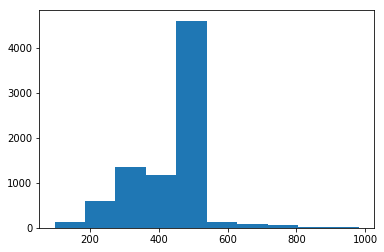

In [66]:
plt.hist(row_sz[row_sz<1000])

(array([ 235.,  733., 2205., 2979., 1807.,   98.,   27.,   33.,    7.,   10.]),
 array([102., 190., 278., 366., 454., 542., 630., 718., 806., 894., 982.]),
 <a list of 10 Patch objects>)

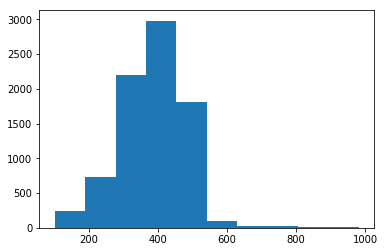

In [73]:
plt.hist(col_sz[col_sz<1000])

In [17]:
def get_model(sz, bs):
    tfms=tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data=ImageClassifierData.from_csv(PATH, 'train', 
                                  label_csv, tfms=tfms,bs=bs, 
                                  test_name='test', suffix='.jpg',
                                  val_idxs=val_idxs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [20]:
data = get_model(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [21]:
learn=ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 432/432 [00:40<00:00, 10.57it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████▏| 117/128 [00:02<00:00, 46.22it/s, loss=34.4]


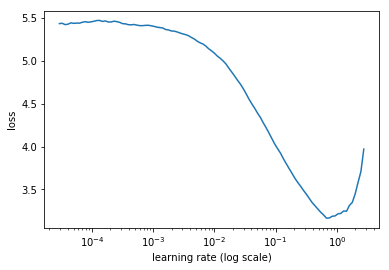

In [84]:
learn.lr_find()
learn.sched.plot()

In [85]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.60136    0.773956   0.830892  
    1      0.844149   0.54664    0.857324                    



[0.5466403, 0.857324218377471]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 77%|███████▋  | 98/128 [00:02<00:00, 36.59it/s, loss=2.58] 


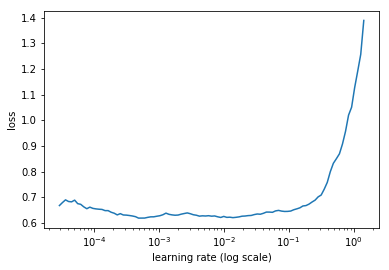

In [81]:
learn.lr_find()
learn.sched.plot()

In [86]:
learn.precompute = False
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.696834   0.491349   0.864062  
    1      0.619532   0.461751   0.865495                    
    2      0.600102   0.448505   0.861198                    



[0.44850487, 0.861197916790843]

In [87]:
learn.save('resnet34-44-86')

In [87]:
learn.load('resnet34-44-86')

In [89]:
learn.set_data(get_model(299,bs))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 116/128 [01:03<00:06,  1.84it/s, loss=2.55] 

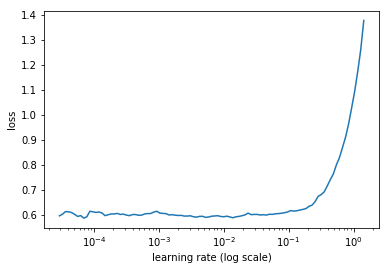

In [90]:
learn.lr_find()
learn.sched.plot()

In [91]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  4%|▍         | 5/128 [00:04<01:42,  1.20it/s, loss=0.531]

Exception in thread Thread-33:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.588739   0.416522   0.872005  
    1      0.556475   0.403553   0.876888                    
    2      0.521186   0.394565   0.873926                    



[0.39456457, 0.873925780877471]

In [94]:
learn.unfreeze()

In [95]:
learn.save('resnet34-39-87')

In [ ]:
learn.load('resnet34-39-87')

In [96]:
lrs = [1e-4, 1e-3, 1e-2]

In [23]:
learn.precompute=False
learn.load('resnet34-39-87')
learn.unfreeze()
learn.set_data(get_model(299,bs))
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

FileNotFoundError: [Errno 2] No such file or directory: 'data/competitions/dog-breed-identification/tmp/340/models/resnet34-39-87.h5'